<a href="https://colab.research.google.com/github/kundajelab/adar_editing/blob/master/xgboost_with_shap/NEIL1_XGBOOST_WITH_TREESHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
##### ## Uncomment these lines if running as a google colab notebook: 
#!pip install numpy==1.15
#! git clone https://github.com/kundajelab/adar_editing
#import os
#os.chdir("adar_editing/xgboost_with_shap/")
#!pip install shap
#!pip install --upgrade xgboost
#!pip install cufflinks
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))


In [98]:
%load_ext autoreload
%autoreload 2   

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))


In [99]:
#helper utilities for model training and interpretation 
import shap
import sys 
sys.path.append('..')

from helpers import * 

# load JS visualization code to notebook
shap.initjs()
import warnings
warnings.filterwarnings('ignore')

#visualization utilities 
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import chart_studio.plotly as plotly
import numpy as np
from plotly.offline import iplot
from plotly.graph_objs import Heatmap




## Neil1 xgboost with TreeShap <a name='outline'>
<ol>
    <li><a href=#3>Computational Dataset</a></li>
    <li><a href=#4>Computational Dataset Feature Subsets</a></li>
    <li><a href=#5>Exclude mut features</a></li>
 </ol>


## Neil1 Computational features <a name='3'>
<a href=#outline>Home</a>

In [100]:
import pandas as pd 
import xgboost
data=pd.read_csv("../../xin_feature_matrices/neil1_computational.features.csv",header=0,sep=',',index_col=0)
#impute missing features 
#data=pd.read_csv("../missing_feature_imputation/neil1.computational.imputed.tsv",header=0,sep='\t',index_col=0)


In [101]:
data.head()

editing_value  minimum_free_energy  ensemble_free_energy  \
rna_id                                                             
1                0.58                -40.1                -41.29   
2                0.46                -38.5                -39.30   
3                0.49                -39.1                -40.32   
4                0.48                -44.1                -44.78   
5                0.59                -40.8                -41.45   

        mfe_frequency  ensemble_diversity  sim_nor_score  \
rna_id                                                     
1            0.143877               29.39         0.7426   
2            0.274518               10.93         0.9125   
3            0.138271               28.24         0.9301   
4            0.331605                4.19         1.0000   
5            0.346702                8.25         0.7400   

        probability_active_conf  num_mutations  mut_exist  mut_type  ...  \
rna_id                                                               ...   
1                      0.137610              1          1  mismatch  ...   
2                      0.131799              1          1  mismatch  ...   
3                      0.065449              1          1  mismatch  ...   
4                      0.321958              1          1  mismatch  ...   
5                      0.169233              1          1  mismatch  ...   

        d3_length_stem  d3_length_hairpin d3_length_bulge  \
rna_id                                                      
1                    9                NaN             NaN   
2                    5                NaN             NaN   
3                    5                NaN             NaN   
4                    5                NaN             NaN   
5                    9                NaN             NaN   

       d3_length_internal_es d3_length_internal_ecs d3_5prm_cp_hairpin  \
rna_id                                                                   
1                        NaN                    NaN                NaN   
2                        NaN                    NaN                NaN   
3                        NaN                    NaN                NaN   
4                        NaN                    NaN                NaN   
5                        NaN                    NaN                NaN   

       d3_5prm_cp_bulge d3_3prm_cp_bulge  d3_5prm_cp_internal  \
rna_id                                                          
1                   NaN              NaN                  NaN   
2                   NaN              NaN                  NaN   
3                   NaN              NaN                  NaN   
4                   NaN              NaN                  NaN   
5                   NaN              NaN                  NaN   

        d3_3prm_cp_internal  
rna_id                       
1                       NaN  
2                       NaN  
3                       NaN  
4                       NaN  
5                       NaN  

[5 rows x 126 columns]

In [6]:
#remove any null editing level values 
data=data[~data["editing_value"].isnull().values]

In [7]:
data=format_for_xgboost(data)

#set a random seed so code is reproducible 
random.seed(1234)
train_split,eval_split,test_split=split_train_test_eval_by_mut_pos(data)

(432, 202)
{20.0: 3, 21.0: 3, 22.0: 4, 23.0: 4, 24.0: 3, 25.0: 4, 26.0: 3, 27.0: 4, 28.0: 4, 29.0: 4, 30.0: 3, 31.0: 4, 32.0: 4, 33.0: 4, 34.0: 4, 35.0: 4, 36.0: 4, 41.0: 21, 42.0: 21, 43.0: 18, 44.0: 17, 45.0: 20, 46.0: 20, 48.0: 20, 49.0: 21, 50.0: 21, 51.0: 20, 52.0: 20, 53.0: 21, 54.0: 19, 55.0: 21, 56.0: 20, 57.0: 15, 58.0: 16, 59.0: 17, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 21}


In [8]:
#Remove any non-varying features 
train_novar=get_singleval_features(train_split)
eval_novar=get_singleval_features(eval_split)
test_novar=get_singleval_features(test_split)
uniform_features_to_drop=list(set(train_novar+eval_novar+test_novar))

In [9]:
#Remove any null features 
train_null=get_high_missingness_features(train_split,percent_missing=0.5)
eval_null=get_high_missingness_features(eval_split,percent_missing=0.5)
test_null=get_high_missingness_features(test_split,percent_missing=0.5)
null_features_to_drop=list(set(train_null+eval_null+test_null))

In [10]:
to_drop=list(set(uniform_features_to_drop+null_features_to_drop))
print("\n".join(to_drop))

u1_3prm_cp_bulge
u2_length_stem
u1_5prm_cp_internal
u3_length_stem
u2_5prm_cp_internal:U:A
d3_struct:S
u2_length_internal_es
d2_5prm_cp_hairpin
d2_exist
u3_5prm_cp_hairpin
site_5prm_cp_internal:A:U
site_length_hairpin
d2_5prm_cp_bulge:U:G
site_struct:M
d2_5prm_cp_bulge:G:U
u3_3prm_cp_bulge
u1_length_hairpin
d3_3prm_cp_internal
mut_prev_struct:B
site_5prm_cp_bulge:G:U
u2_5prm_cp_bulge:G:U
mut_prev_struct:H
u3_length_bulge
u3_length_internal_es
d2_5prm_cp_bulge:A:U
d1_5prm_cp_bulge
d1_struct:S
site_next_nt:C
d3_5prm_cp_bulge
u2_length_internal_ecs
d3_length_bulge
d1_exist
u1_length_internal_ecs
u3_length_internal_ecs
d1_5prm_cp_hairpin
u2_length_bulge
d2_length_bulge
site_5prm_cp_bulge:C:G
u2_3prm_cp_bulge:C:G
mut_ref_nt:A
mut_ref_struct:B
u1_length_internal_es
site_length_bulge
u2_5prm_cp_internal:C:G
d3_5prm_cp_hairpin
d2_3prm_cp_internal:G:U
u3_3prm_cp_internal
d3_length_hairpin
site_next_struct:S
u3_length
d1_length_bulge
d2_3prm_cp_bulge:U:G
u2_3prm_cp_internal:G:U
d1_length_hairpin

In [11]:
train_split=train_split.drop(to_drop,axis=1)
eval_split=eval_split.drop(to_drop,axis=1)
test_split=test_split.drop(to_drop,axis=1)

In [12]:
train_y=train_split['editing_value']
train_X=train_split.drop(['editing_value'],axis=1)

eval_y=eval_split['editing_value']
eval_X=eval_split.drop(['editing_value'],axis=1)

test_y=test_split['editing_value']
test_X=test_split.drop(['editing_value'],axis=1)

In [13]:
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)


(299, 106)
(299,)
(88, 106)
(88,)
(87, 106)
(87,)


In [14]:
## format matrixes for xgboost 
dtrain=xgboost.DMatrix(train_X,train_y)
deval=xgboost.DMatrix(eval_X,eval_y)
dtest=xgboost.DMatrix(test_X,test_y)

In [15]:
## set model training parameters 
param=dict() 
param['nthread'] = 20
#rmse -- root mean square error 
# mae -- mean absolute error 
# map -- mean average precision 
# auc -- area under ROC curve 
# aucpr -- area under precision recall curve 
param['eval_metric'] = ['auc','mae','map','aucpr','rmse']

In [16]:
evallist = [(deval, 'eval'), (dtrain, 'train')]


In [17]:
num_round = 1000
random.seed(1234)
bst = xgboost.train(param, dtrain, num_round, evallist,early_stopping_rounds=10)

[0]	eval-auc:0.74161	eval-mae:0.19036	eval-map:1.00000	eval-aucpr:0.53194	eval-rmse:0.22261	train-auc:0.81808	train-mae:0.21137	train-map:1.00000	train-aucpr:0.57459	train-rmse:0.24567
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[1]	eval-auc:0.73974	eval-mae:0.15645	eval-map:1.00000	eval-aucpr:0.52792	eval-rmse:0.18679	train-auc:0.82515	train-mae:0.15626	train-map:1.00000	train-aucpr:0.58006	train-rmse:0.18280
[2]	eval-auc:0.75861	eval-mae:0.12918	eval-map:1.00000	eval-aucpr:0.54807	eval-rmse:0.15754	train-auc:0.82996	train-mae:0.11647	train-map:1.00000	train-aucpr:0.59059	train-rmse:0.13633
[3]	eval-auc:0.77056	eval-mae:0.10797	eval-map:1.00000	eval-aucpr:0.55174	eval-rmse:0.13552	train-auc:0.83177	train-mae:0.08825	train-map:1.00000	train-aucpr:0.59367	train-rmse:0.10394
[4]	eval-auc:0.77304	eval-mae:0.09767	eval-map:1.00000	eval-aucpr:0.55504	eval-rmse:0.12606	train-auc:0.83474	train

[44]	eval-auc:0.78062	eval-mae:0.05932	eval-map:1.00000	eval-aucpr:0.55986	eval-rmse:0.10732	train-auc:0.84228	train-mae:0.00301	train-map:1.00000	train-aucpr:0.60674	train-rmse:0.00459
[45]	eval-auc:0.78063	eval-mae:0.05932	eval-map:1.00000	eval-aucpr:0.55986	eval-rmse:0.10731	train-auc:0.84228	train-mae:0.00289	train-map:1.00000	train-aucpr:0.60675	train-rmse:0.00441
[46]	eval-auc:0.78059	eval-mae:0.05928	eval-map:1.00000	eval-aucpr:0.55985	eval-rmse:0.10730	train-auc:0.84228	train-mae:0.00279	train-map:1.00000	train-aucpr:0.60675	train-rmse:0.00430
[47]	eval-auc:0.78044	eval-mae:0.05924	eval-map:1.00000	eval-aucpr:0.55978	eval-rmse:0.10725	train-auc:0.84228	train-mae:0.00270	train-map:1.00000	train-aucpr:0.60675	train-rmse:0.00419
[48]	eval-auc:0.78045	eval-mae:0.05926	eval-map:1.00000	eval-aucpr:0.55978	eval-rmse:0.10732	train-auc:0.84229	train-mae:0.00261	train-map:1.00000	train-aucpr:0.60676	train-rmse:0.00402
[49]	eval-auc:0.78045	eval-mae:0.05931	eval-map:1.00000	eval-aucpr:0.5

In [19]:
# save to binary file for faster loading
bst.save_model('neil1.computational.model')
# save model to text file 
bst.dump_model('neil1.computational.raw.txt')


In [20]:
## get model predictions on the test, training, and eval splits 
test_pred = bst.predict(dtest)
train_pred=bst.predict(dtrain)
eval_pred=bst.predict(deval)

In [21]:
#calculate R^2, which is representative of variance explained 
# https://datascienceplus.com/extreme-gradient-boosting-with-r/
# https://arxiv.org/pdf/1706.06060.pdf

residuals = test_y - test_pred

y_test_mean = np.mean(test_pred)
print(y_test_mean)
#calculate total sum of squares 
tss=sum((test_y-y_test_mean)*(test_y-y_test_mean))
print(tss)
# Calculate residual sum of squares
rss =  sum(residuals*residuals)
print(rss)
# Calculate R-squared
rsq  =  1 - (rss/tss)
print('The R-square of the test data is ', round(rsq,3), '\n')

0.30053523
5.51970174684816
0.7964329128255669
The R-square of the test data is  0.856 



In [22]:
## get performance metrics on full dataset 
from helpers import * 
print_aggregate_peformance_metrics(train_y,train_pred,
                                   eval_y,eval_pred,
                                   test_y,test_pred,
                                   positive_thresh=0.2)

Train
	Spearman corr : SpearmanrResult(correlation=0.9988612177633522, pvalue=0.0)
	Pearson corr : (0.9999822244238856, 0.0)
	MAE : 0.0009377480176025165
	MAPE : 0.009609483351601427
	RMSE : 0.001424182271407219
	auPRC : 1.0
	auROC : 1.0
Eval
	Spearman corr : SpearmanrResult(correlation=0.8941795980641831, pvalue=9.254842187403053e-32)
	Pearson corr : (0.8969727855821028, 3.1118577970504064e-32)
	MAE : 0.05911387685051357
	MAPE : 0.29601920532405496
	RMSE : 0.10758939811043079
	auPRC : 0.9783790415081971
	auROC : 0.9708894878706199
Test
	Spearman corr : SpearmanrResult(correlation=0.924699906757626, pvalue=2.081365103504013e-37)
	Pearson corr : (0.9286456177035547, 2.2957064085377398e-38)
	MAE : 0.05377220218209014
	MAPE : 0.18786155338427532
	RMSE : 0.09567863552980672
	auPRC : 0.9660257729297996
	auROC : 0.9593406593406593


In [23]:
## Correlation values 
from scipy.stats import spearmanr,pearsonr
spearman_train=spearmanr(train_y,train_pred)
spearman_eval=spearmanr(eval_y,eval_pred)
spearman_test=spearmanr(test_y,test_pred)

pearson_train=pearsonr(train_y,train_pred)
pearson_eval=pearsonr(eval_y,eval_pred)
pearson_test=pearsonr(test_y,test_pred)

print("Spearman correlation:")
print("Train:"+str(spearman_train))
print("Eval:"+str(spearman_eval))
print("Test:"+str(spearman_test))
print("\n")
print("Pearson correlation:")
print("Train:"+str(pearson_train))
print("Eval:"+str(pearson_eval))
print("Test:"+str(pearson_test))

Spearman correlation:
Train:SpearmanrResult(correlation=0.9988612177633522, pvalue=0.0)
Eval:SpearmanrResult(correlation=0.8941795980641831, pvalue=9.254842187403053e-32)
Test:SpearmanrResult(correlation=0.924699906757626, pvalue=2.081365103504013e-37)


Pearson correlation:
Train:(0.9999822244238856, 0.0)
Eval:(0.8969727855821028, 3.1118577970504064e-32)
Test:(0.9286456177035547, 2.2957064085377398e-38)


In [24]:
## MAE
from sklearn.metrics import mean_absolute_error
mae_train=mean_absolute_error(train_y,train_pred)
print("MAE Train:"+str(mae_train))

mae_eval=mean_absolute_error(eval_y,eval_pred)
print("MAE Eval:"+str(mae_eval))

mae_test=mean_absolute_error(test_y,test_pred)
print("MAE Test:"+str(mae_test))


MAE Train:0.0009377480176025165
MAE Eval:0.05911387685051357
MAE Test:0.05377220218209014


In [25]:
## MAPE
pseudocount=0.01
mape_train=np.mean(np.abs((train_y - train_pred) /(pseudocount+train_y))) * 100
print("MAPE Train:"+str(mape_train)+"%")

mape_eval=np.mean(np.abs((eval_y - eval_pred) /(pseudocount+eval_y))) * 100
print("MAPE Eval:"+str(mape_eval)+"%")

mape_test=np.mean(np.abs((test_y - test_pred) /(pseudocount+test_y))) * 100
print("MAPE Test:"+str(mape_test)+"%")

MAPE Train:0.9609483351601427%
MAPE Eval:29.601920532405497%
MAPE Test:18.78615533842753%


In [26]:
## RMSE
from sklearn.metrics import mean_squared_error
import math 
rmse_train=math.sqrt(mean_squared_error(train_y,train_pred))
print("RMSE Train:"+str(rmse_train))

rmse_eval=math.sqrt(mean_squared_error(eval_y,eval_pred))
print("RMSE Eval:"+str(rmse_eval))

rmse_test=math.sqrt(mean_squared_error(test_y,test_pred))
print("RMSE Test:"+str(rmse_test))


RMSE Train:0.001424182271407219
RMSE Eval:0.10758939811043079
RMSE Test:0.09567863552980672


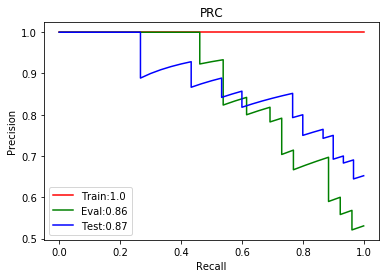

In [27]:
## PRC 
## PRC only valid for binary outcomes. 
## Editing levels < 0.5 are labeled as "0". 
## Editing levels >= 0.5 are labeled as "1". 

from sklearn.metrics import auc, precision_recall_curve

precision_train,recall_train,prc_thresholds_train=precision_recall_curve(train_y>=0.5,train_pred)
precision_eval,recall_eval,prc_thresholds_eval=precision_recall_curve(eval_y>=0.5,eval_pred)
precision_test,recall_test,prc_thresholds_test=precision_recall_curve(test_y>=0.5,test_pred)

auprc_train=auc(recall_train,precision_train)
auprc_eval=auc(recall_eval,precision_eval)
auprc_test=auc(recall_test,precision_test)

plt.plot(recall_train,precision_train,'r',label="Train:"+str(round(auprc_train,2)))
plt.plot(recall_eval,precision_eval,'g',label="Eval:"+str(round(auprc_eval,2)))
plt.plot(recall_test,precision_test,'b',label="Test:"+str(round(auprc_test,2)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PRC")
plt.legend()

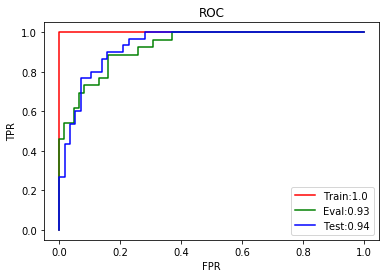

In [28]:
## ROC
from sklearn.metrics import roc_curve, roc_auc_score
fpr_train,tpr_train,roc_thresholds_train=roc_curve(train_y>=0.5,train_pred)
fpr_eval,tpr_eval,roc_thresholds_eval=roc_curve(eval_y>=0.5,eval_pred)
fpr_test,tpr_test,roc_thresholds_test=roc_curve(test_y>=0.5,test_pred)

auroc_train=roc_auc_score(train_y>=0.5,train_pred)
auroc_eval=roc_auc_score(eval_y>=0.5,eval_pred)
auroc_test=roc_auc_score(test_y>=0.5,test_pred)

plt.plot(fpr_train,tpr_train,'r',label="Train:"+str(round(auroc_train,2)))
plt.plot(fpr_eval,tpr_eval,'g',label="Eval:"+str(round(auroc_eval,2)))
plt.plot(fpr_test,tpr_test,'b',label="Test:"+str(round(auroc_test,2)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend()

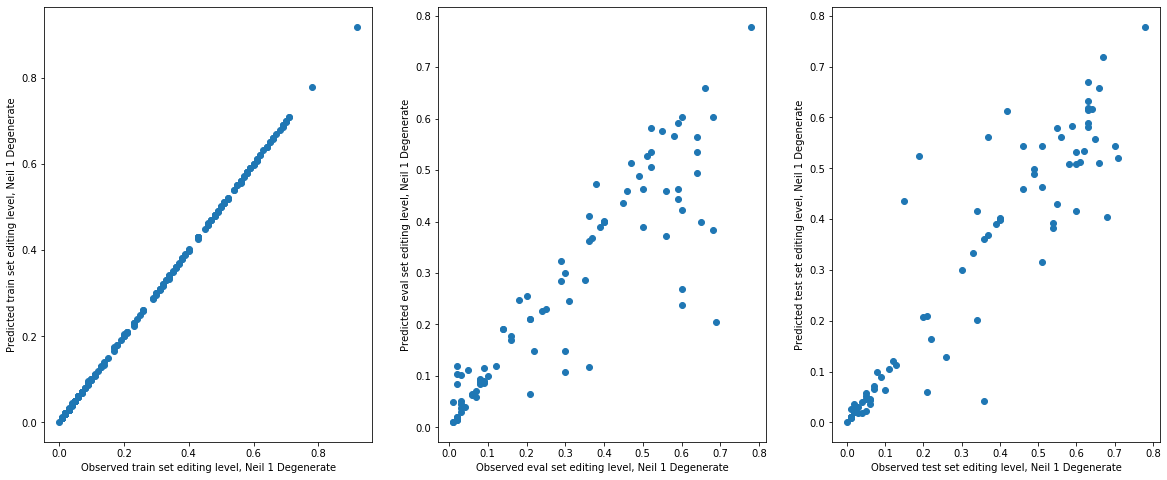

In [29]:
#plot the test set predictions 
matplotlib.rcParams['figure.figsize'] = [20, 8]
plt.subplot(1,3,1)
plt.plot(list(train_y),list(train_pred),'o')
plt.xlabel("Observed train set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted train set editing level, Neil 1 Degenerate")
plt.subplot(1,3,2)
plt.plot(list(eval_y),list(eval_pred),'o')
plt.xlabel("Observed eval set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted eval set editing level, Neil 1 Degenerate")
plt.subplot(1,3,3)
plt.plot(list(test_y),list(test_pred),'o')
plt.xlabel("Observed test set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted test set editing level, Neil 1 Degenerate")

plt.show()

In [30]:
import plotnine
from plotnine import *
test_df=pd.DataFrame({'Observed':test_y,
                     'Predicted':test_pred,
                     'Dataset':'NEIL1_COMP'})

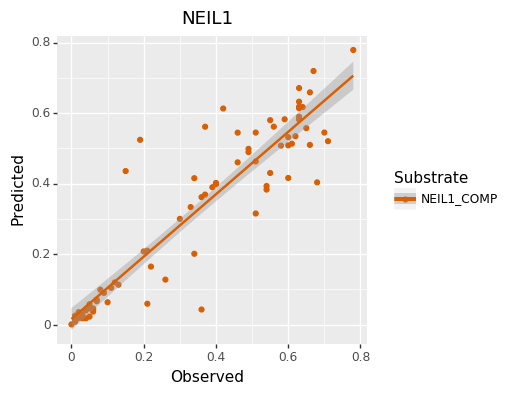

<ggplot: (8729825223053)>


In [31]:
plotnine.options.figure_size = (4, 4)

p=(ggplot(test_df, aes('Observed', 'Predicted', color='factor(Dataset)'))
 + geom_point()
 + stat_smooth(method='lm')
 + scale_color_manual(values=['#d95f02'],name="Substrate")
 + ggtitle("NEIL1"))
print(p)
ggsave(plot=p, filename='NEIL1.comp.substrate.svg',width=4,height=4,units='in')


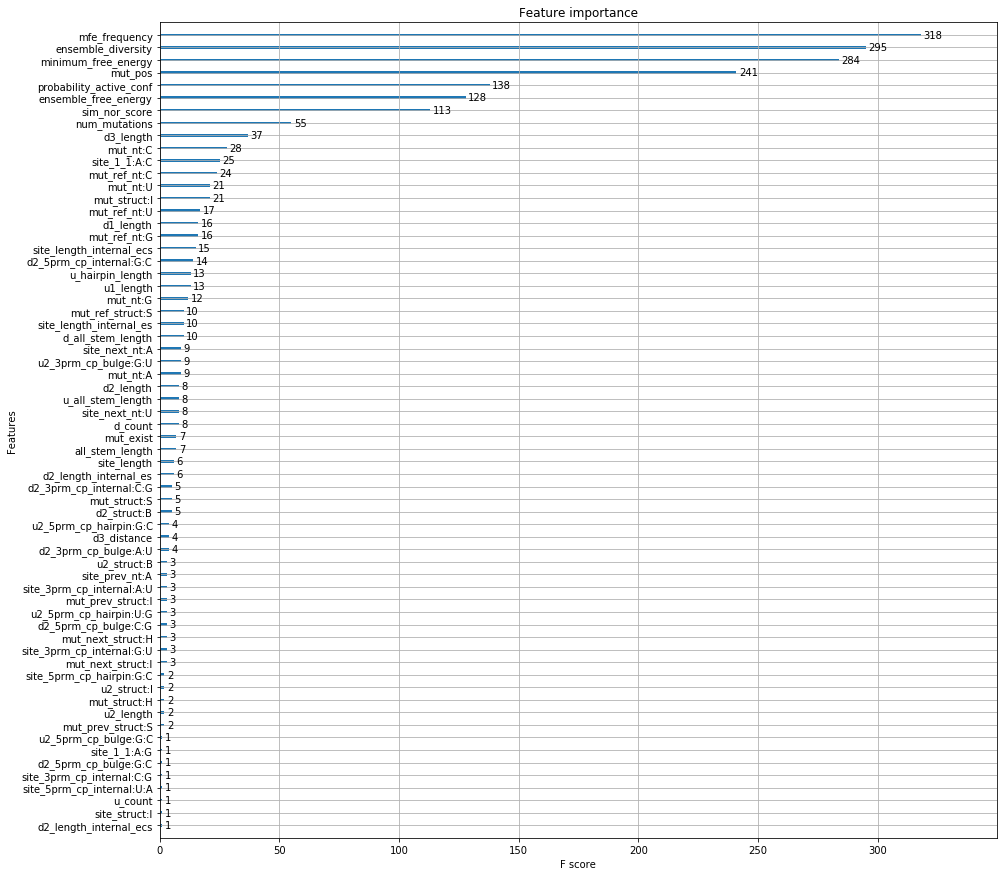

In [32]:
matplotlib.rcParams['figure.figsize'] = [15, 15]
xgboost.plot_importance(bst)

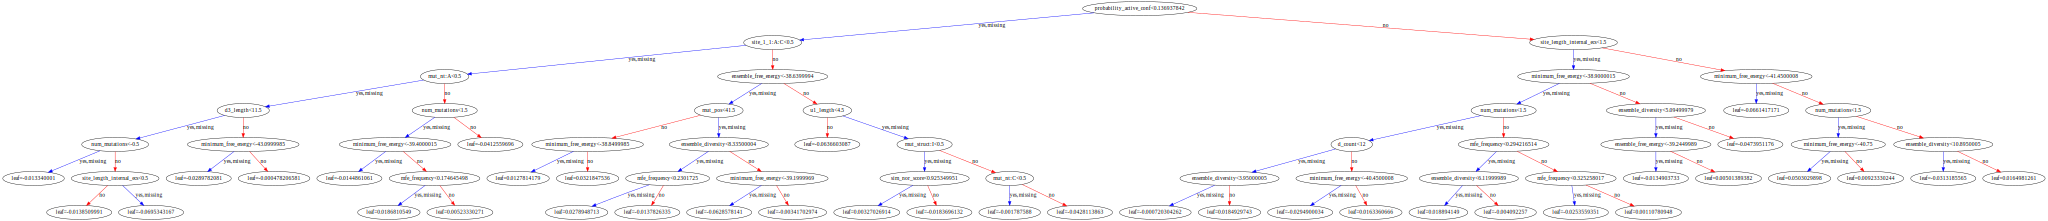

In [33]:
import graphviz
xgboost.to_graphviz(bst, num_trees=2)


In [34]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(test_X)
shap_values.shape

(87, 106)

In [36]:
test_X.iloc[6,:].shape

(106,)

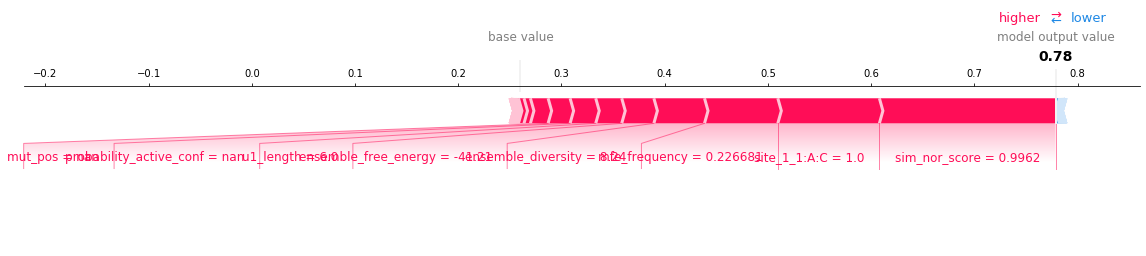

In [37]:
test_y=pd.DataFrame(test_y)
max_index=test_y.index[test_y['editing_value'] == max(test_y['editing_value'])]
max_row=test_y.index.get_loc(max_index[0])
# visualize prediction for isoform with the highest editing level 
# visualize prediction for isoform with the highest editing level 
shap.initjs()
matplotlib=True
shap.force_plot(explainer.expected_value, shap_values[max_row,:], test_X.iloc[max_row,:],matplotlib=True,show=False)
plt.savefig("NEIL1.comp.visualize_prediction.highest.svg", format='svg', width=7, height=1, dpi=300, bbox_inches="tight")

In [38]:
 max(test_y['editing_value'])

0.78

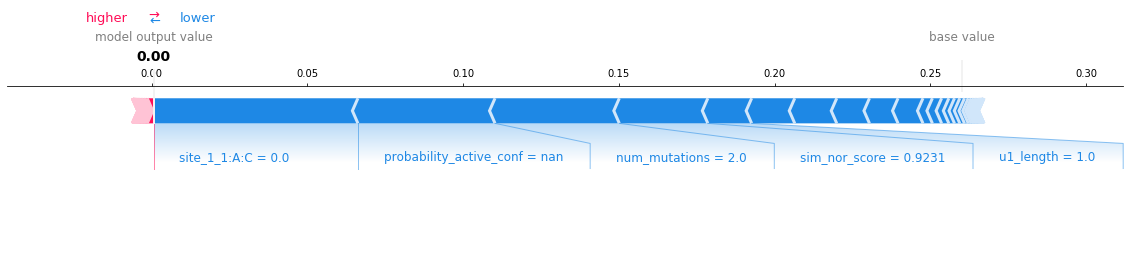

In [39]:
# visualize prediction for isoform with the lowest editing level 
shap.initjs()
min_index=test_y.index[test_y['editing_value'] == min(test_y['editing_value'])]
min_row=test_y.index.get_loc(min_index[0])
matplotlib=True
shap.force_plot(explainer.expected_value, shap_values[min_row,:], test_X.iloc[min_row,:],matplotlib=True,show=False)
plt.savefig("NEIL1.comp.visualize_prediction.lowest.svg", format='svg', width=7, height=1, dpi=300, bbox_inches="tight")

In [40]:
 min(test_y['editing_value'])

0.0

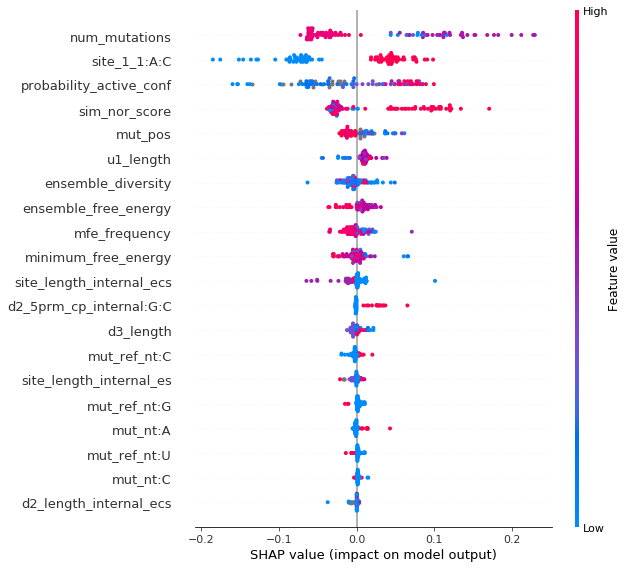

In [41]:
# summarize the effect of all the features 
shap.summary_plot(shap_values, test_X,show=False)
plt.savefig("NEIL1.comp.shap.svg", format='svg',width=20,height=10,dpi=300,bbox_inches="tight")


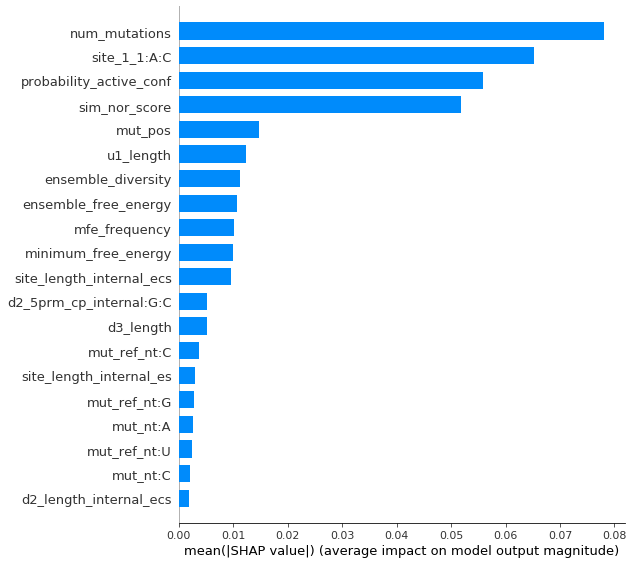

In [42]:
# We can also just take the mean absolute value of the SHAP values for each feature 
# to get a standard bar plot (produces stacked bars for multi-class outputs):
shap.summary_plot(shap_values, test_X, plot_type="bar")

In [43]:
mean_abs_shap_vals=np.mean(abs(shap_values),axis=0)
features=test_X.columns
shap_dict=pd.DataFrame({'feature':features,
          'mean_abs_shap':mean_abs_shap_vals})
shap_dict.to_csv("NEIL1_comp_shap_mean_abs.txt",index=False,sep='\t')

In [44]:
shap_dict

feature  mean_abs_shap
0        minimum_free_energy       0.009860
1       ensemble_free_energy       0.010730
2              mfe_frequency       0.010124
3         ensemble_diversity       0.011299
4              sim_nor_score       0.051733
..                       ...            ...
101  d2_3prm_cp_internal:U:A       0.000000
102  d2_3prm_cp_internal:U:G       0.000000
103              d3_distance       0.000803
104                d3_length       0.005121
105           d3_length_stem       0.000000

[106 rows x 2 columns]

In [45]:
## Compute pairwise interaction values from TreeShap
shap_interaction_values=explainer.shap_interaction_values(test_X)
shap_interaction_values.shape

(87, 106, 106)

In [46]:
##Average interaction values across the datapoints in the test set 
mean_interaction_values=np.mean(shap_interaction_values,axis=0)

In [47]:
Index=test_X.columns
Cols=test_X.columns
mean_interaction_values_df = pd.DataFrame(mean_interaction_values, index=Index, columns=Cols)

In [48]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
#configure_plotly_browser_state()

trace = Heatmap(z=mean_interaction_values_df.values,
                   x=Cols,
                   y=Index)
iplot([trace],show_link=False)


## Computational Dataset: Feature Subsets<a name='4'>
<a href=#outline>Home</a>

In [49]:
shap_values=pd.DataFrame(shap_values,columns=Cols)

['site_prev_nt*', 'site_next_nt*']


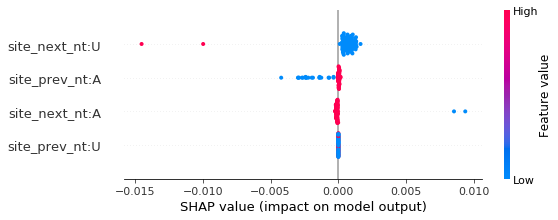

Contribution/Total:0.0049185436
['free_energy*', 'sim_nor_score*', 'probability_active_conf*', 'minimum_free_energy*', 'ensemble_free_energy*', 'mfe_frequency*', 'ensemble_diversity*']


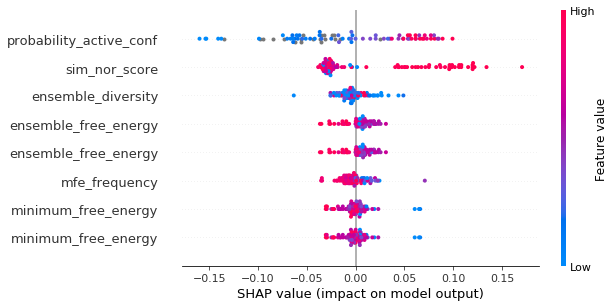

Contribution/Total:0.4549039
['u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_internal_es*', 'd1_length_internal_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_internal*', 'd1_3prm_cp_internal*']


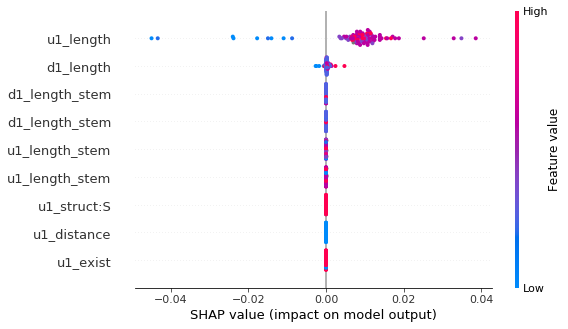

Contribution/Total:0.034115314
['num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*']


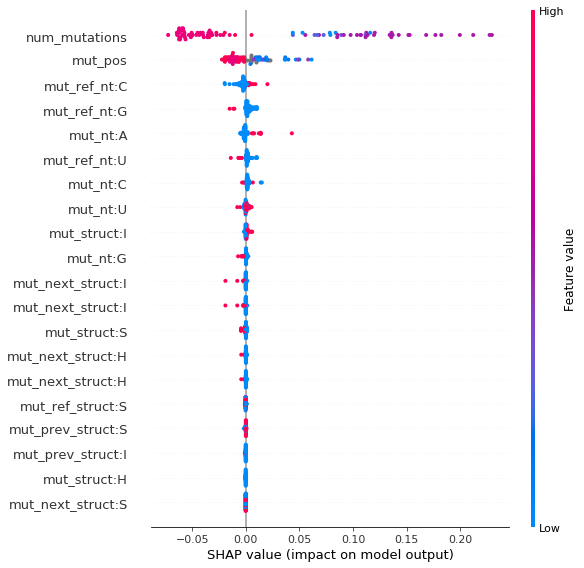

Contribution/Total:0.29874083
['site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*']


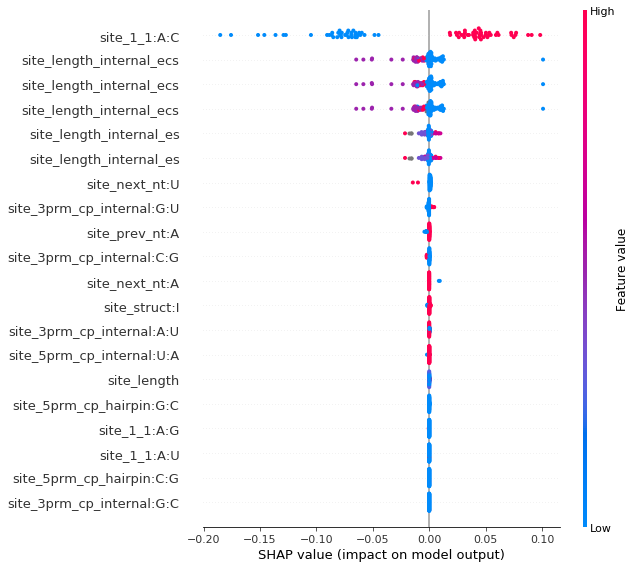

Contribution/Total:0.27610156
['u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_internal_es*', 'u2_length_internal_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_internal*', 'u2_3prm_cp_internal*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulge*', 'u3_length_internal_es*', 'u3_length_internal_ecs*', 'u3_5prm_cp_hairpin*', 'u3_5prm_cp_bulge*', 'u3_3prm_cp_bulge*', 'u3_5prm_cp_internal*', 'u3_3prm_cp_internal*']


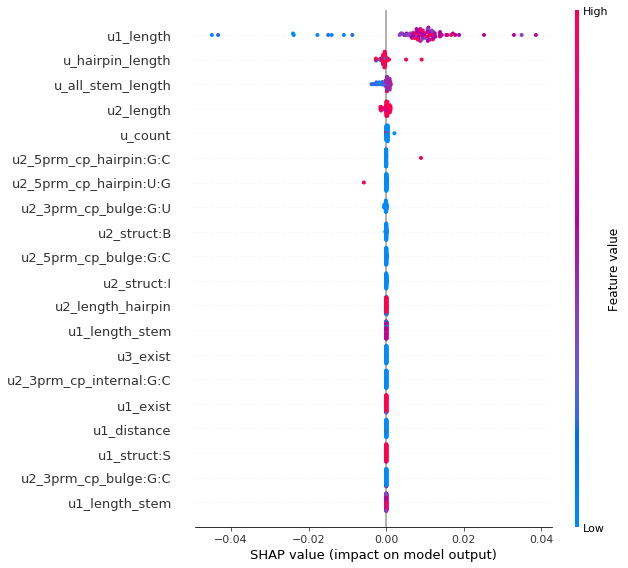

Contribution/Total:0.039667822
['d_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_internal_es*', 'd1_length_internal_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_internal*', 'd1_3prm_cp_internal*', 'd2_exist*', 'd2_distance*', 'd2_struct*', 'd2_length*', 'd2_length_stem*', 'd2_length_hairpin*', 'd2_length_bulge*', 'd2_length_internal_es*', 'd2_length_internal_ecs*', 'd2_5prm_cp_hairpin*', 'd2_5prm_cp_bulge*', 'd2_3prm_cp_bulge*', 'd2_5prm_cp_internal*', 'd2_3prm_cp_internal*', 'd3_exist*', 'd3_distance*', 'd3_struct*', 'd3_length*', 'd3_length_stem*', 'd3_length_hairpin*', 'd3_length_bulge*', 'd3_length_internal_es*', 'd3_length_internal_ecs*', 'd3_5prm_cp_hairpin*', 'd3_5prm_cp_bulge*', 'd3_3prm_cp_bulge*', 'd3_5prm_cp_internal*', 'd3_3prm_cp_internal*']


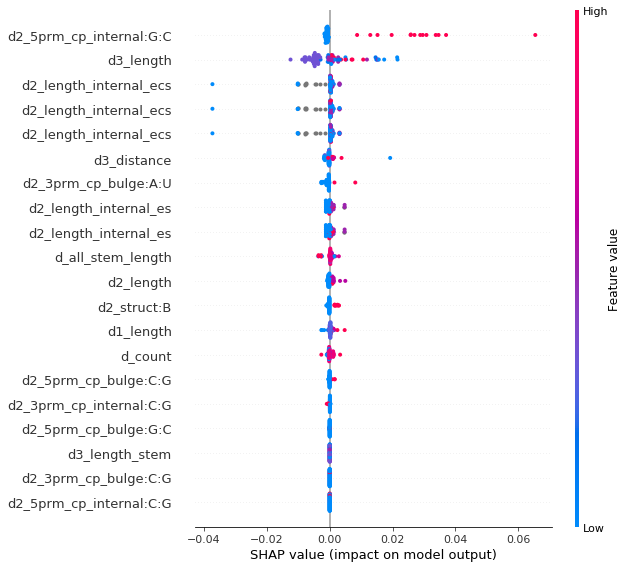

Contribution/Total:0.0586387
['u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_internal_es*', 'u2_length_internal_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_internal*', 'u2_3prm_cp_internal*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulge*', 'u3_length_internal_es*', 'u3_length_internal_ecs*', 'u3_5prm_cp_hairpin*', 'u3_5prm_cp_bulge*', 'u3_3prm_cp_bulge*', 'u3_5prm_cp_internal*', 'u3_3prm_cp_internal*', 'd_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 

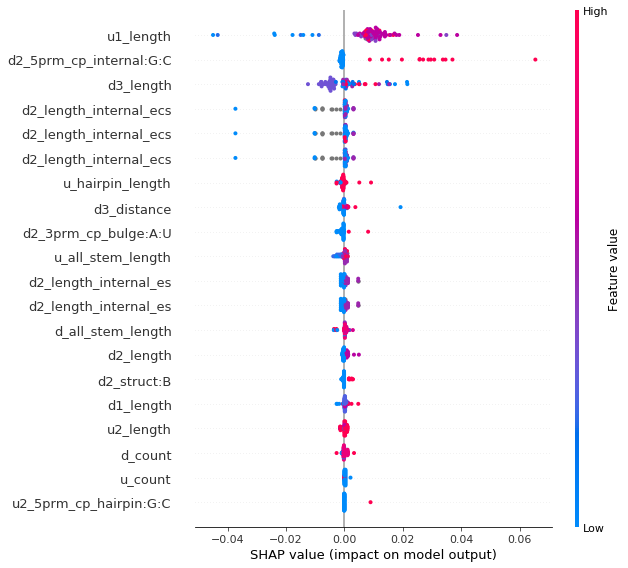

Contribution/Total:0.09830652
['num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*']


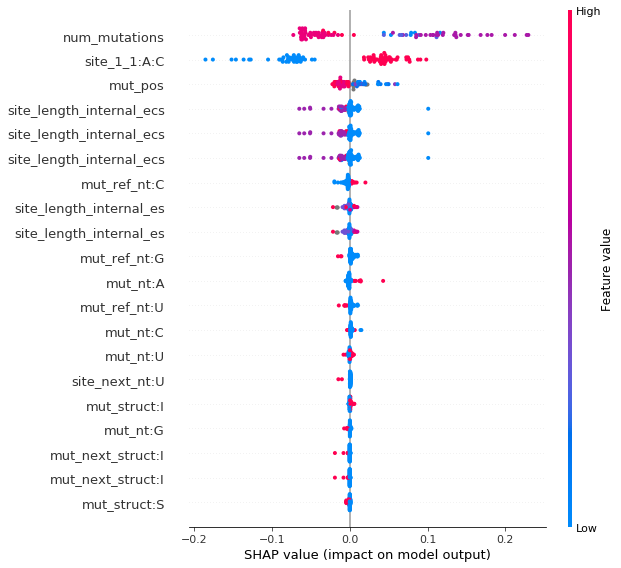

Contribution/Total:0.5748424
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*', 'num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*', 'd_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_internal_es*', 'd1_length_internal_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_internal*', 'd1_3prm_cp_internal*', 'd2_exist*', 'd2_distance*', 'd2_s

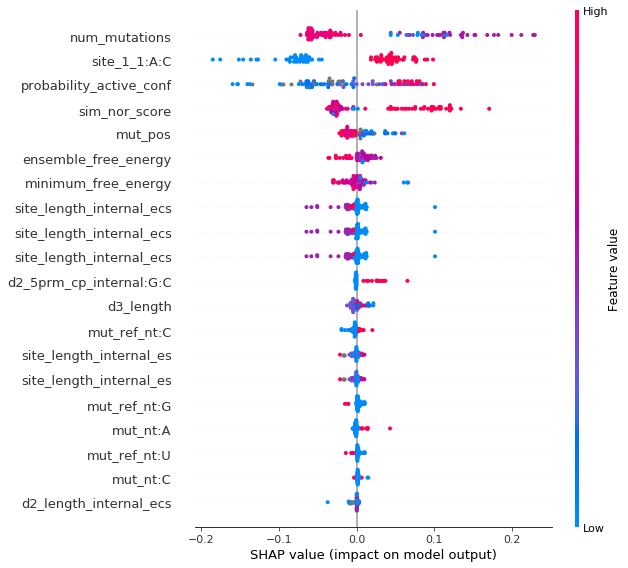

Contribution/Total:0.979964
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*', 'num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*', 'u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*', '

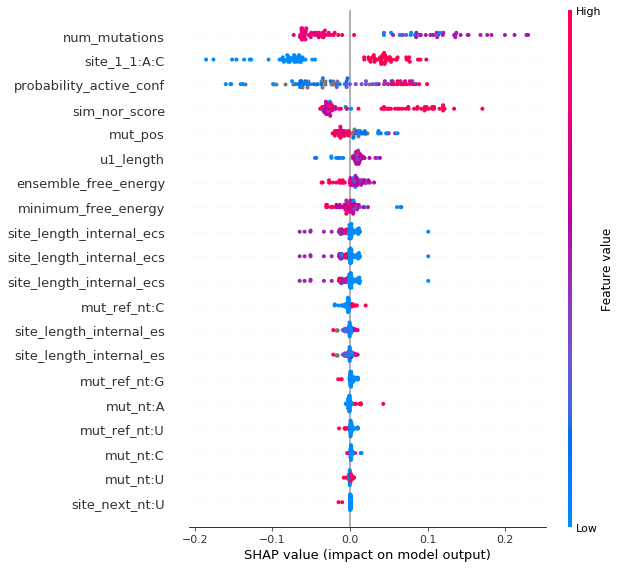

Contribution/Total:0.9609931
['site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*']


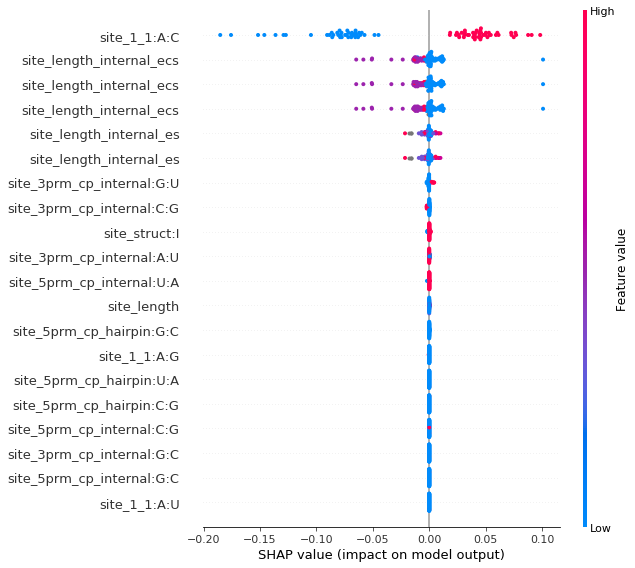

Contribution/Total:0.271183
['site_prev_nt*', 'site_next_nt*']


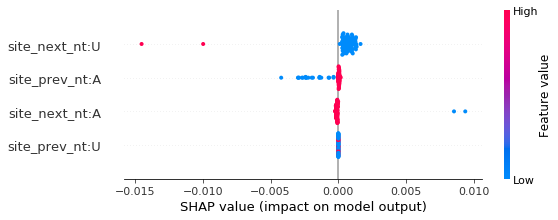

Contribution/Total:0.0049185436
['mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*']


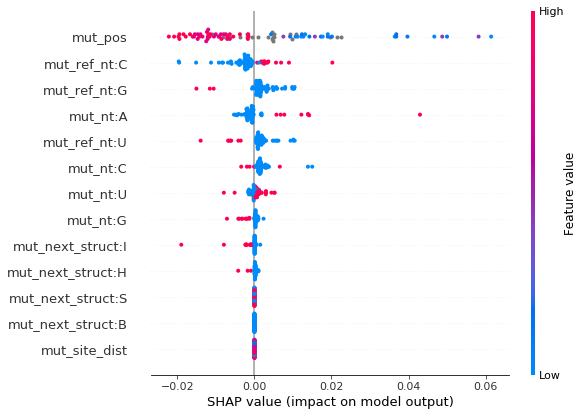

Contribution/Total:0.08247193
['mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'site_prev_nt*', 'site_next_nt*']


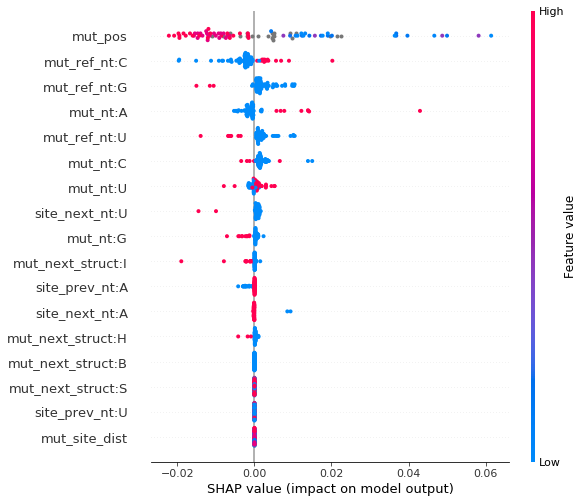

Contribution/Total:0.08739047
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*', 'u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_internal_es*', 'u2_length_internal_ecs*', 'u2_5prm_c

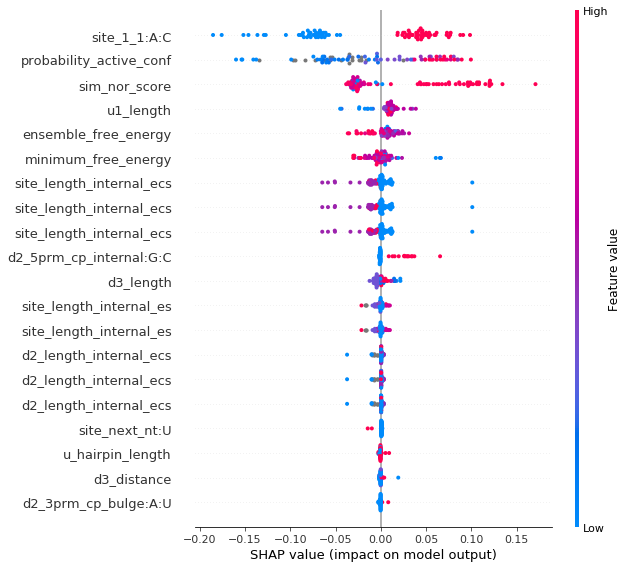

Contribution/Total:0.720891
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*']


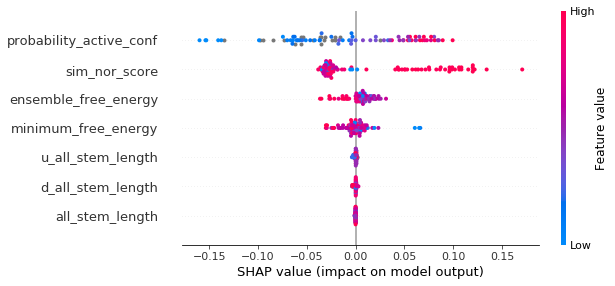

Contribution/Total:0.3464829


In [50]:
from feature_subsets import * 
subset_names=["sub_site_seq","thermodynamic","u1_d1","mut","site","u","d","u_d","mut_site","no_up","no_down","site_struct","site_seq","mut_seq","mut_seq_site","no_mut","overall_structure"]
subset_contribs=[]
for subset in [sub_site_seq,thermodynamic, u1_d1,mut,site,u,d,u_d,mut_site,no_up,no_down,site_struct,site_seq,mut_seq,mut_seq_site,no_mut,overall_structure]: 
  print(subset)
  cur_features=filter_features(shap_values,subset)
  cur_feature_shap=shap_values[cur_features].values 
  cur_feature_data_X=test_X[cur_features]
  shap.summary_plot(cur_feature_shap, cur_feature_data_X)#,sort=False,max_display=50)
  contrib=shap_contribs_subgroup(shap_values,subset)
  subset_contribs.append(contrib)
  print("Contribution/Total:"+str(contrib))

In [51]:
subset_contrib_df=pd.DataFrame({'Subset':subset_names,
                               'Contribution':[100*i for i in subset_contribs]})

In [52]:
subset_contrib_df=subset_contrib_df.sort_values(by=['Contribution'],ascending=False)
subset_contrib_df.reset_index(inplace=True, drop=True) 

In [53]:
from pandas.api.types import CategoricalDtype


In [54]:
subset_cat = CategoricalDtype(categories=list(subset_contrib_df['Subset']), ordered=True)

# Cast the existing categories into the new category. Due to a bug in pandas
# we need to do this via a string.
subset_contrib_df['Subset_Cat'] = subset_contrib_df['Subset'].astype(str).astype(subset_cat)


In [55]:
subset_contrib_df

Subset  Contribution         Subset_Cat
0               no_up     97.996402              no_up
1             no_down     96.099311            no_down
2              no_mut     72.089100             no_mut
3            mut_site     57.484239           mut_site
4       thermodynamic     45.490390      thermodynamic
5   overall_structure     34.648290  overall_structure
6                 mut     29.874083                mut
7                site     27.610156               site
8         site_struct     27.118301        site_struct
9                 u_d      9.830652                u_d
10       mut_seq_site      8.739047       mut_seq_site
11            mut_seq      8.247193            mut_seq
12                  d      5.863870                  d
13                  u      3.966782                  u
14              u1_d1      3.411531              u1_d1
15           site_seq      0.491854           site_seq
16       sub_site_seq      0.491854       sub_site_seq

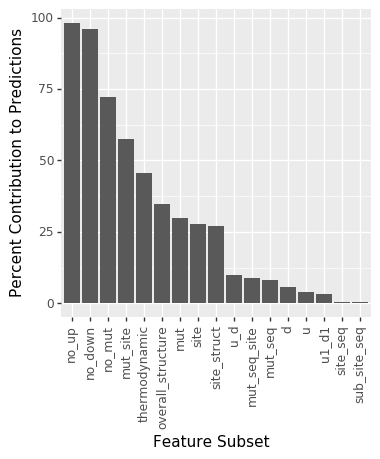

<ggplot: (8729985942277)>

In [56]:
p=(ggplot(subset_contrib_df, aes('Subset_Cat', 'Contribution'))
 + geom_bar(stat='identity')
 + xlab("Feature Subset")
 + ylab("Percent Contribution to Predictions")
 + theme(axis_text_x=element_text(angle=90))
)
ggsave(plot=p, filename='NEIL1.comp.subset.importance.svg',width=5,height=4,units='in')
p

## No Mut Features <a name='5'>
<a href=#outline>Home</a>

In [57]:
## Read in the data 
import feature_subsets
import pandas as pd 
data=pd.read_csv("../../xin_feature_matrices/neil1_computational.features.csv",header=0,sep=',',index_col=0)
#drop all mut features
cur_features=filter_features(data,feature_subsets.mut)
cur_features.remove('mut_pos')
data=data.drop(cur_features,axis=1)
#data.head


In [58]:
#remove any null editing level values 
data=data[~data["editing_value"].isnull().values]

In [59]:
data=format_for_xgboost(data)

#set a random seed so code is reproducible 
random.seed(1234)
train_split,eval_split,test_split=split_train_test_eval_by_mut_pos(data)

(432, 175)
{20.0: 3, 21.0: 3, 22.0: 4, 23.0: 4, 24.0: 3, 25.0: 4, 26.0: 3, 27.0: 4, 28.0: 4, 29.0: 4, 30.0: 3, 31.0: 4, 32.0: 4, 33.0: 4, 34.0: 4, 35.0: 4, 36.0: 4, 41.0: 21, 42.0: 21, 43.0: 18, 44.0: 17, 45.0: 20, 46.0: 20, 48.0: 20, 49.0: 21, 50.0: 21, 51.0: 20, 52.0: 20, 53.0: 21, 54.0: 19, 55.0: 21, 56.0: 20, 57.0: 15, 58.0: 16, 59.0: 17, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 21}


In [60]:
#Remove any non-varying features 
train_novar=get_singleval_features(train_split)
eval_novar=get_singleval_features(eval_split)
test_novar=get_singleval_features(test_split)
uniform_features_to_drop=list(set(train_novar+eval_novar+test_novar))

In [61]:
#Remove any null features 
train_null=get_high_missingness_features(train_split)
eval_null=get_high_missingness_features(eval_split)
test_null=get_high_missingness_features(test_split)
null_features_to_drop=list(set(train_null+eval_null+test_null))

In [62]:
to_drop=list(set(uniform_features_to_drop+null_features_to_drop))
to_drop.append("mut_pos")
print("\n".join(to_drop))

u1_3prm_cp_bulge
u2_length_stem
u1_5prm_cp_internal
u3_length_stem
u2_5prm_cp_internal:U:A
d3_struct:S
u2_length_internal_es
d2_5prm_cp_hairpin
d2_exist
u3_5prm_cp_hairpin
site_5prm_cp_internal:A:U
site_length_hairpin
d2_5prm_cp_bulge:U:G
site_struct:M
d2_5prm_cp_bulge:G:U
u3_3prm_cp_bulge
u1_length_hairpin
d3_3prm_cp_internal
site_5prm_cp_bulge:G:U
u2_5prm_cp_bulge:G:U
u3_length_bulge
u3_length_internal_es
d2_5prm_cp_bulge:A:U
d1_5prm_cp_bulge
d1_struct:S
site_next_nt:C
d3_5prm_cp_bulge
u2_length_internal_ecs
d3_length_bulge
d1_exist
u1_length_internal_ecs
u3_length_internal_ecs
d1_5prm_cp_hairpin
u2_length_bulge
d2_length_bulge
site_5prm_cp_bulge:C:G
u2_3prm_cp_bulge:C:G
u1_length_internal_es
site_length_bulge
u2_5prm_cp_internal:C:G
d3_5prm_cp_hairpin
d2_3prm_cp_internal:G:U
u3_3prm_cp_internal
d3_length_hairpin
site_next_struct:S
u3_length
d1_length_bulge
d2_3prm_cp_bulge:U:G
u2_3prm_cp_internal:G:U
d1_length_hairpin
d2_3prm_cp_bulge:G:U
d2_3prm_cp_bulge:U:A
u3_5prm_cp_bulge
d1_len

In [63]:
train_split=train_split.drop(to_drop,axis=1)
eval_split=eval_split.drop(to_drop,axis=1)
test_split=test_split.drop(to_drop,axis=1)

In [64]:
train_y=train_split['editing_value']
train_X=train_split.drop(['editing_value'],axis=1)

eval_y=eval_split['editing_value']
eval_X=eval_split.drop(['editing_value'],axis=1)

test_y=test_split['editing_value']
test_X=test_split.drop(['editing_value'],axis=1)

In [65]:
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)


(299, 85)
(299,)
(88, 85)
(88,)
(87, 85)
(87,)


In [66]:
## format matrixes for xgboost 
import xgboost
dtrain=xgboost.DMatrix(train_X,train_y)
deval=xgboost.DMatrix(eval_X,eval_y)
dtest=xgboost.DMatrix(test_X,test_y)

In [67]:
## set model training parameters 
param=dict() 
param['nthread'] = 20
#rmse -- root mean square error 
# mae -- mean absolute error 
# map -- mean average precision 
# auc -- area under ROC curve 
# aucpr -- area under precision recall curve 
param['eval_metric'] = ['auc','mae','map','aucpr','rmse']

In [68]:
evallist = [(deval, 'eval'), (dtrain, 'train')]


In [69]:
num_round = 1000
random.seed(1234)
bst = xgboost.train(param, dtrain, num_round, evallist,early_stopping_rounds=10)

[0]	eval-auc:0.71663	eval-mae:0.20306	eval-map:1.00000	eval-aucpr:0.50146	eval-rmse:0.23500	train-auc:0.79641	train-mae:0.21924	train-map:1.00000	train-aucpr:0.53787	train-rmse:0.25260
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[1]	eval-auc:0.74568	eval-mae:0.16439	eval-map:1.00000	eval-aucpr:0.53682	eval-rmse:0.18712	train-auc:0.82181	train-mae:0.16200	train-map:1.00000	train-aucpr:0.57265	train-rmse:0.18648
[2]	eval-auc:0.74905	eval-mae:0.13696	eval-map:1.00000	eval-aucpr:0.53923	eval-rmse:0.16106	train-auc:0.82854	train-mae:0.12089	train-map:1.00000	train-aucpr:0.58669	train-rmse:0.13900
[3]	eval-auc:0.74579	eval-mae:0.11612	eval-map:1.00000	eval-aucpr:0.53825	eval-rmse:0.14724	train-auc:0.83109	train-mae:0.09265	train-map:1.00000	train-aucpr:0.59053	train-rmse:0.10685
[4]	eval-auc:0.75313	eval-mae:0.10153	eval-map:1.00000	eval-aucpr:0.54064	eval-rmse:0.13930	train-auc:0.83281	train

[44]	eval-auc:0.76097	eval-mae:0.06175	eval-map:1.00000	eval-aucpr:0.54792	eval-rmse:0.14035	train-auc:0.84227	train-mae:0.00341	train-map:1.00000	train-aucpr:0.60661	train-rmse:0.00526
[45]	eval-auc:0.76085	eval-mae:0.06166	eval-map:1.00000	eval-aucpr:0.54781	eval-rmse:0.14044	train-auc:0.84228	train-mae:0.00312	train-map:1.00000	train-aucpr:0.60662	train-rmse:0.00478
[46]	eval-auc:0.76107	eval-mae:0.06153	eval-map:1.00000	eval-aucpr:0.54795	eval-rmse:0.14044	train-auc:0.84228	train-mae:0.00300	train-map:1.00000	train-aucpr:0.60663	train-rmse:0.00450
[47]	eval-auc:0.76108	eval-mae:0.06146	eval-map:1.00000	eval-aucpr:0.54796	eval-rmse:0.14058	train-auc:0.84229	train-mae:0.00278	train-map:1.00000	train-aucpr:0.60666	train-rmse:0.00418
[48]	eval-auc:0.76108	eval-mae:0.06137	eval-map:1.00000	eval-aucpr:0.54796	eval-rmse:0.14061	train-auc:0.84229	train-mae:0.00267	train-map:1.00000	train-aucpr:0.60669	train-rmse:0.00404
[49]	eval-auc:0.76108	eval-mae:0.06128	eval-map:1.00000	eval-aucpr:0.5

In [70]:
# save to binary file for faster loading
bst.save_model('neil1.computational.nomut.model')
# save model to text file 
bst.dump_model('neil1.computational.nomut.raw.txt')


In [71]:
## get model predictions on the test, training, and eval splits 
test_pred = bst.predict(dtest)
train_pred=bst.predict(dtrain)
eval_pred=bst.predict(deval)

In [72]:
## Correlation values 
from scipy.stats import spearmanr,pearsonr
spearman_train=spearmanr(train_y,train_pred)
spearman_eval=spearmanr(eval_y,eval_pred)
spearman_test=spearmanr(test_y,test_pred)

pearson_train=pearsonr(train_y,train_pred)
pearson_eval=pearsonr(eval_y,eval_pred)
pearson_test=pearsonr(test_y,test_pred)

print("Spearman correlation:")
print("Train:"+str(spearman_train))
print("Eval:"+str(spearman_eval))
print("Test:"+str(spearman_test))
print("\n")
print("Pearson correlation:")
print("Train:"+str(pearson_train))
print("Eval:"+str(pearson_eval))
print("Test:"+str(pearson_test))

Spearman correlation:
Train:SpearmanrResult(correlation=0.9988698498154691, pvalue=0.0)
Eval:SpearmanrResult(correlation=0.8428311775938269, pvalue=7.3338437979342635e-25)
Test:SpearmanrResult(correlation=0.8946480848467883, pvalue=1.739129043859488e-31)


Pearson correlation:
Train:(0.9999914288571825, 0.0)
Eval:(0.8223850445075856, 8.936504861301696e-23)
Test:(0.8936885925356927, 2.5048161095800473e-31)


In [73]:
## MAE
from sklearn.metrics import mean_absolute_error
mae_train=mean_absolute_error(train_y,train_pred)
print("MAE Train:"+str(mae_train))

mae_eval=mean_absolute_error(eval_y,eval_pred)
print("MAE Eval:"+str(mae_eval))

mae_test=mean_absolute_error(test_y,test_pred)
print("MAE Test:"+str(mae_test))


MAE Train:0.0006792882592596405
MAE Eval:0.060132813231003564
MAE Test:0.05650523182989537


In [74]:
## MAPE
pseudocount=0.01
mape_train=np.mean(np.abs((train_y - train_pred) /(pseudocount+train_y))) * 100
print("MAPE Train:"+str(mape_train)+"%")

mape_eval=np.mean(np.abs((eval_y - eval_pred) /(pseudocount+eval_y))) * 100
print("MAPE Eval:"+str(mape_eval)+"%")

mape_test=np.mean(np.abs((test_y - test_pred) /(pseudocount+test_y))) * 100
print("MAPE Test:"+str(mape_test)+"%")

MAPE Train:0.5914438006791172%
MAPE Eval:17.090091914236936%
MAPE Test:20.47296269523389%


In [75]:
## RMSE
from sklearn.metrics import mean_squared_error
import math 
rmse_train=math.sqrt(mean_squared_error(train_y,train_pred))
print("RMSE Train:"+str(rmse_train))

rmse_eval=math.sqrt(mean_squared_error(eval_y,eval_pred))
print("RMSE Eval:"+str(rmse_eval))

rmse_test=math.sqrt(mean_squared_error(test_y,test_pred))
print("RMSE Test:"+str(rmse_test))


RMSE Train:0.0010182071424138432
RMSE Eval:0.14072152829976572
RMSE Test:0.11503599515034933


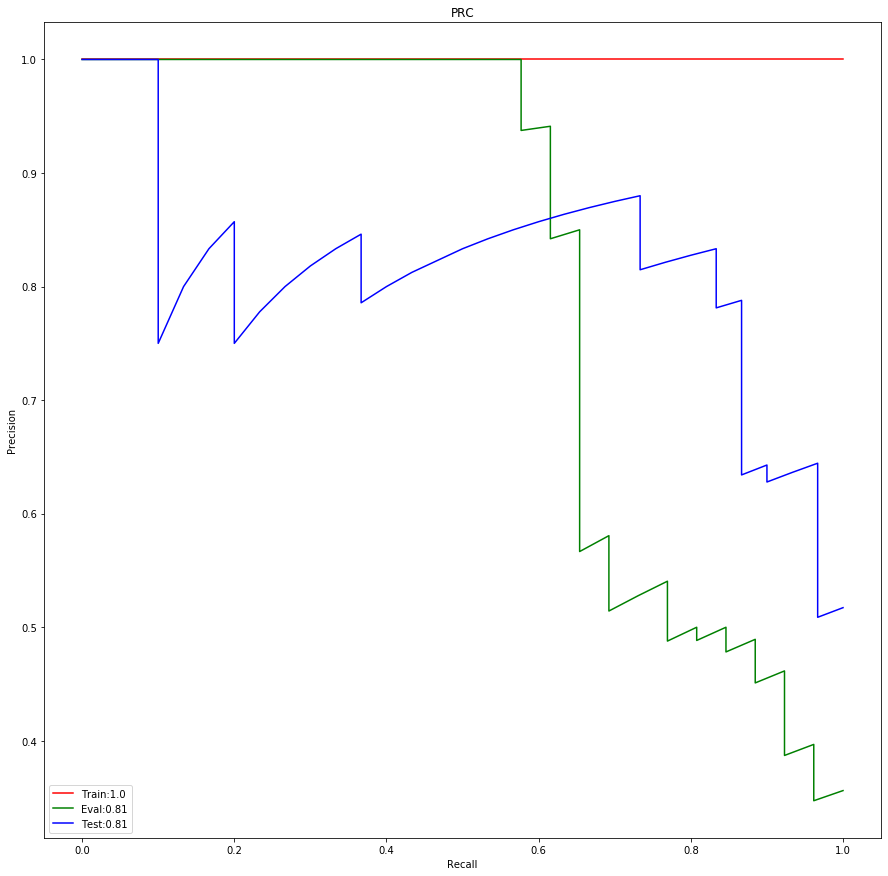

In [76]:
## PRC 
## PRC only valid for binary outcomes. 
## Editing levels < 0.5 are labeled as "0". 
## Editing levels >= 0.5 are labeled as "1". 

from sklearn.metrics import auc, precision_recall_curve

precision_train,recall_train,prc_thresholds_train=precision_recall_curve(train_y>=0.5,train_pred)
precision_eval,recall_eval,prc_thresholds_eval=precision_recall_curve(eval_y>=0.5,eval_pred)
precision_test,recall_test,prc_thresholds_test=precision_recall_curve(test_y>=0.5,test_pred)

auprc_train=auc(recall_train,precision_train)
auprc_eval=auc(recall_eval,precision_eval)
auprc_test=auc(recall_test,precision_test)

plt.plot(recall_train,precision_train,'r',label="Train:"+str(round(auprc_train,2)))
plt.plot(recall_eval,precision_eval,'g',label="Eval:"+str(round(auprc_eval,2)))
plt.plot(recall_test,precision_test,'b',label="Test:"+str(round(auprc_test,2)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PRC")
plt.legend()

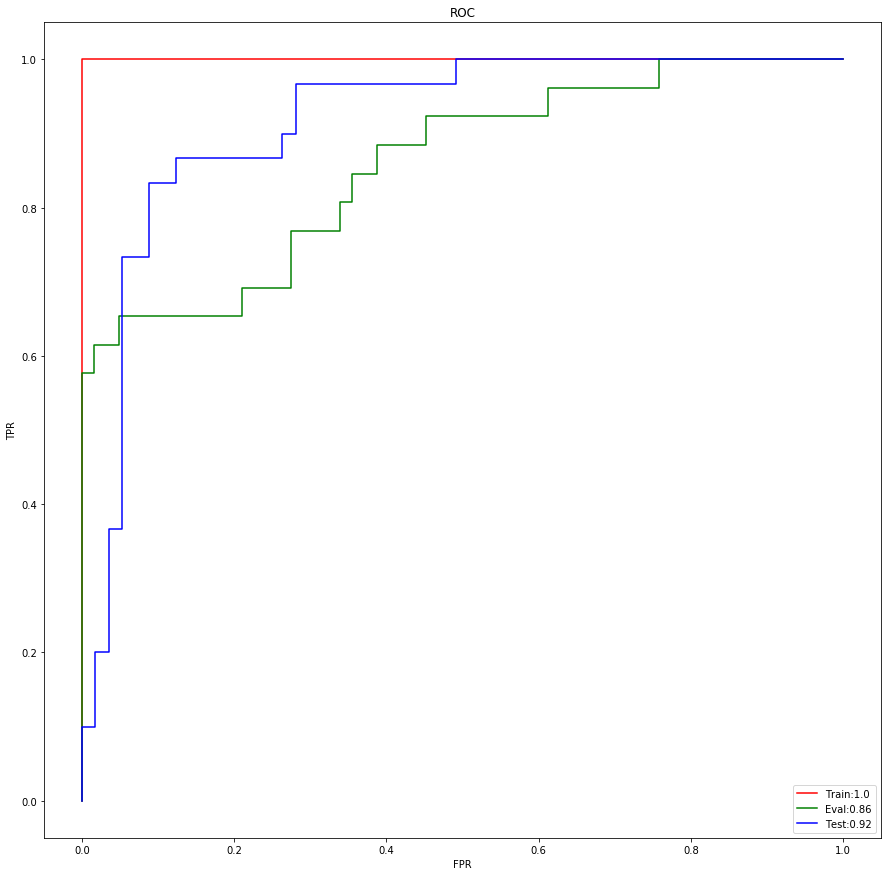

In [77]:
## ROC
from sklearn.metrics import roc_curve, roc_auc_score
fpr_train,tpr_train,roc_thresholds_train=roc_curve(train_y>=0.5,train_pred)
fpr_eval,tpr_eval,roc_thresholds_eval=roc_curve(eval_y>=0.5,eval_pred)
fpr_test,tpr_test,roc_thresholds_test=roc_curve(test_y>=0.5,test_pred)

auroc_train=roc_auc_score(train_y>=0.5,train_pred)
auroc_eval=roc_auc_score(eval_y>=0.5,eval_pred)
auroc_test=roc_auc_score(test_y>=0.5,test_pred)

plt.plot(fpr_train,tpr_train,'r',label="Train:"+str(round(auroc_train,2)))
plt.plot(fpr_eval,tpr_eval,'g',label="Eval:"+str(round(auroc_eval,2)))
plt.plot(fpr_test,tpr_test,'b',label="Test:"+str(round(auroc_test,2)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend()

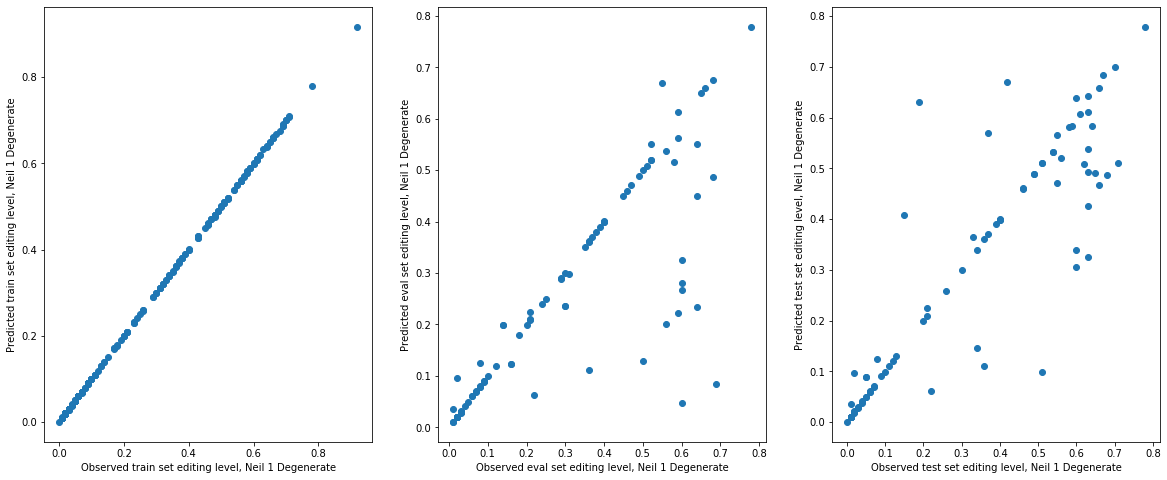

In [79]:
#plot the test set predictions 
import matplotlib 
matplotlib.rcParams['figure.figsize'] = [20, 8]
plt.subplot(1,3,1)
plt.plot(list(train_y),list(train_pred),'o')
plt.xlabel("Observed train set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted train set editing level, Neil 1 Degenerate")
plt.subplot(1,3,2)
plt.plot(list(eval_y),list(eval_pred),'o')
plt.xlabel("Observed eval set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted eval set editing level, Neil 1 Degenerate")
plt.subplot(1,3,3)
plt.plot(list(test_y),list(test_pred),'o')
plt.xlabel("Observed test set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted test set editing level, Neil 1 Degenerate")

plt.show()

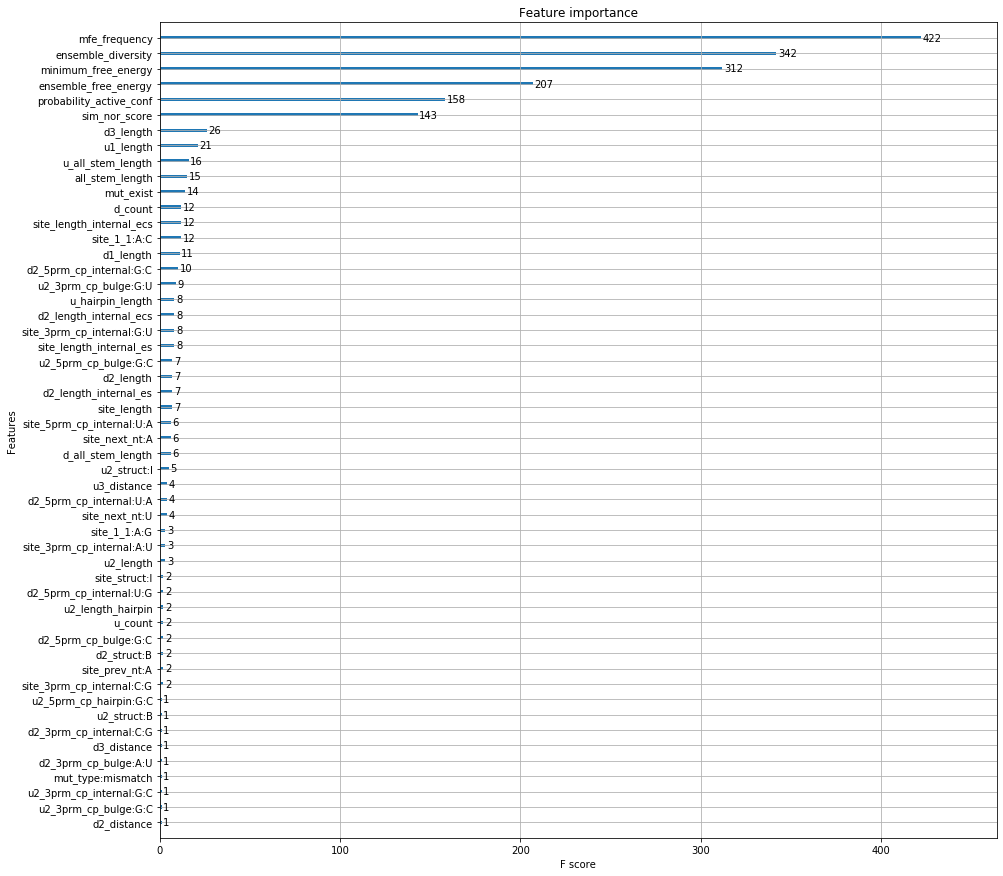

In [80]:
matplotlib.rcParams['figure.figsize'] = [15, 15]
xgboost.plot_importance(bst)

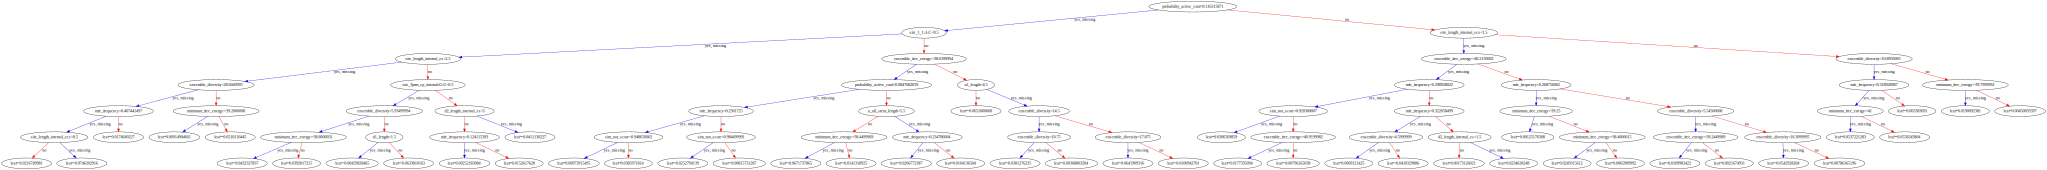

In [81]:
xgboost.to_graphviz(bst, num_trees=2)


In [82]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(test_X)
shap_values.shape

(87, 85)

In [86]:
test_y=pd.DataFrame(test_y)
max_index=test_y.index[test_y['editing_value'] == max(test_y['editing_value'])]
max_row=test_y.index.get_loc(max_index[0])
# visualize prediction for isoform with the highest editing level 
#shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[max_row,:], test_X.iloc[max_row,:])

In [87]:
# visualize prediction for isoform with the lowest editing level 
shap.initjs()
min_index=test_y.index[test_y['editing_value'] == min(test_y['editing_value'])]
min_row=test_y.index.get_loc(min_index[0])
shap.force_plot(explainer.expected_value, shap_values[min_row,:], test_X.iloc[min_row,:])

In [88]:
# visualize the training set predictions
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values,train_X)

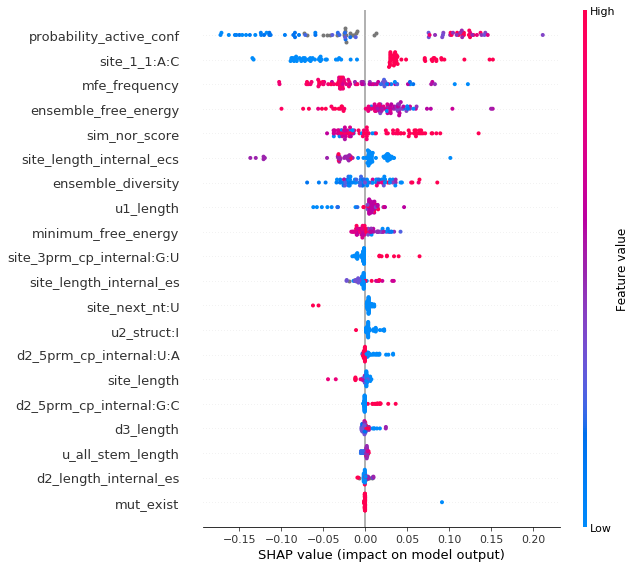

In [89]:
# summarize the effect of all the features 
shap.summary_plot(shap_values, test_X)


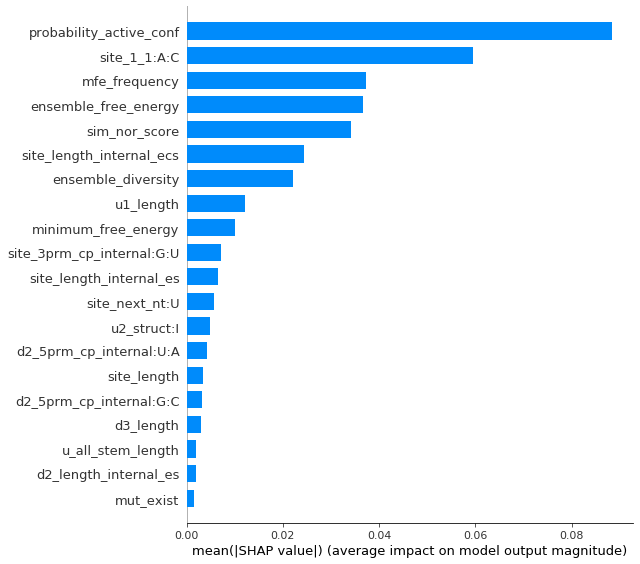

In [90]:
# We can also just take the mean absolute value of the SHAP values for each feature 
# to get a standard bar plot (produces stacked bars for multi-class outputs):
shap.summary_plot(shap_values, test_X, plot_type="bar")

In [91]:
## Compute pairwise interaction values from TreeShap
shap_interaction_values=explainer.shap_interaction_values(test_X)
shap_interaction_values.shape

(87, 85, 85)

In [92]:
##Average interaction values across the datapoints in the test set 
mean_interaction_values=np.mean(shap_interaction_values,axis=0)

In [93]:
Index=test_X.columns
Cols=test_X.columns
mean_interaction_values_df = pd.DataFrame(mean_interaction_values, index=Index, columns=Cols)

In [95]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

trace = Heatmap(z=mean_interaction_values_df.values,
                   x=Cols,
                   y=Index)
iplot([trace],show_link=False)
